# Applying Convolutional Neural Networks to Cryptography for Digital Signing/Verification (Exploratory Points)

To tackle the issue of secure communication, I employed Convolutional Neural Networks (CNNs) for the encryption/decryption (128-bit key) and signing/verification functions. 

The following ipynb contains the parameter Initialization,variable declaration, weight definition, model definition, user input, training, testing, and performance benchmarking against Fernet for signing/verification functions. 

The code is self-explanatory. To run the code, please run the cells in the TensorFlow framework one at a time.

Please Note: User input is mandatory to achieve results. 

I ran the following code through Docker on a Windows 10 Machine with 16 GB RAM and 8-core 3.1 GHz CPU with hyper-threading.

The digital signature model is similar to that used for encryption and decryption. It requires key generation, a signing algorithm, and a signature-verifying algorithm. 
The process for signing and verifying is as follows: Alice sends plaintext and her signature to Bob, who takes Alice’s plaintext, computes the signature and compares it to the signature received. If the signature Bob computed and the signature Alice sent along with her plain text message are the same, then the message’s integrity can be guaranteed; if not, then Bob will know that Eve or another third party has modified the original message. 

Till date, a neural cryptography algorithm that demonstrates a signature/verification capability could not be found.  This notebook presents a successful implementation of digital signatures that uses the internal hidden layer states of Bob’s and Alice’s CNN machines to represent the 32-byte signatures.

Due to the above reason, I believe this work deserves exploratory points.

Further improvement is required to strengthen the algorithm. The code for this algorithm is located in a separate .ipynb file. I wanted to see how the length of the input PlainText would influence verification of the signatures, so four strings of different length were entered.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import sys
import pickle


## Parameter Initialization 

The hyperparameters we are using to tune/experiment with the algorithm

In [2]:
crypto_msg_len = N = 16
crypto_key_len = 16
batch_size = 512
epochs = 1 #50
learning_rate = 0.0008 #Optimizer learning rate

# Function to generate n random messages and keys
def gen_data(n=batch_size, msg_len=crypto_msg_len, key_len=crypto_key_len):
    #return (np.random.randint(0, 2, size=(n, msg_len))*2-1), (np.random.randint(0, 2, size=(n, key_len))*2-1)
    return (np.random.randint(0, 2, size=(n, msg_len))), (np.random.randint(0, 2, size=(n, key_len)))




In [3]:
def conv1d(input_, filter_shape, stride, name="conv1d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', shape=filter_shape, initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.nn.conv1d(input_, w, stride, padding='SAME')
        return conv

In [4]:
# Placeholder variables for Message and Key
msg = tf.placeholder("float", [None, crypto_msg_len])
key = tf.placeholder("float", [None, crypto_key_len])

# Weights for fully connected layers
w_alice = tf.get_variable("alice_w", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_bob = tf.get_variable("bob_w", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_eve1 = tf.get_variable("eve_w1", shape=[N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())
w_eve2 = tf.get_variable("eve_w2", shape=[2 * N, 2 * N], initializer=tf.contrib.layers.xavier_initializer())

# Alice's Machine Network
# FC layer -> Conv Layer (4 1-D convolutions)
alice_input = tf.concat(concat_dim=1, values=[msg, key])
alice_hidden = tf.nn.sigmoid(tf.matmul(alice_input, w_alice))
alice_hidden = tf.expand_dims(alice_hidden, 2)

h0 = tf.nn.relu(conv1d(alice_hidden, [4,1,2], stride=1, name="alice"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="alice"+'_h1_conv'))
h2_alice = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="alice"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2_alice, [1,4,1], stride=1, name="alice"+'_h3_conv'))
alice_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Bob's Machine Network (gets the output (cipher text) of Alice's network)
# FC layer -> Conv Layer (4 1-D convolutions)
bob_input = tf.concat(concat_dim=1, values=[msg, key])
bob_hidden = tf.nn.sigmoid(tf.matmul(bob_input, w_bob))
bob_hidden = tf.expand_dims(bob_hidden, 2)

h0 = tf.nn.relu(conv1d(bob_hidden, [4,1,2], stride=1, name="bob"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="bob"+'_h1_conv'))
h2_bob = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="bob"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2_bob, [1,4,1], stride=1, name="bob"+'_h3_conv'))
bob_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Eve's Machine Network
# FC layer -> FC layer -> Conv Layer (4 1-D convolutions)
eve_input = alice_output
eve_hidden1 = tf.nn.sigmoid(tf.matmul(eve_input, w_eve1))
eve_hidden2 = tf.nn.sigmoid(tf.matmul(eve_hidden1, w_eve2))
eve_hidden2 = tf.expand_dims(eve_hidden2, 2)

h0 = tf.nn.relu(conv1d(eve_hidden2, [4,1,2], stride=1, name="eve"+'_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2,2,4], stride=2, name="eve"+'_h1_conv'))
h2 = tf.nn.relu(conv1d(h1, [1,4,4], stride=1, name="eve"+'_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2, [1,4,1], stride=1, name="eve"+'_h3_conv'))
eve_output = tf.squeeze(h3)


## Neural Cryptography Training

In [5]:
alice_errors, bob_errors, eve_errors = [], [], []

# Loss Functions
decrypt_err_eve = tf.reduce_mean(tf.abs(msg - eve_output))
decrypt_err_alice = tf.reduce_mean(tf.abs(msg - alice_output))
loss_alice = decrypt_err_alice + (1. - decrypt_err_eve) ** 2.
decrypt_err_bob = tf.reduce_mean(tf.abs(msg - bob_output))
loss_bob = decrypt_err_bob + (1. - decrypt_err_eve) ** 2.

# Get training variables corresponding to each network
t_vars = tf.trainable_variables()
alice_vars = [var for var in t_vars if 'alice_' in var.name]
bob_vars =   [var for var in t_vars if 'bob_' in var.name]
eve_vars =   [var for var in t_vars if 'eve_' in var.name]

# Build the optimizers, can play with different optimizers

'''
alice_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                       use_locking=False, name='Adagrad').minimize(loss_alice, var_list=alice_vars)
bob_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                        use_locking=False, name='Adagrad').minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1, 
                        use_locking=False, name='Adagrad').minimize(decrypt_err_eve, var_list=eve_vars)

alice_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_alice, var_list=alice_vars)   
bob_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(decrypt_err_eve, var_list=eve_vars)

'''
alice_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_alice, var_list=alice_vars)   
bob_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(decrypt_err_eve, var_list=eve_vars)

def train(sess):
    # Begin Training
    tf.initialize_all_variables().run(session=sess)
    for i in range(epochs):
        iterations = 2000

        alice_loss, _, _ = _train('alice', iterations, sess)
        alice_errors.append(alice_loss)
        print( 'Training Alice, Epoch:', i + 1, ' error: ', alice_loss)

        _, bob_loss, _ = _train('bob', iterations, sess)
        bob_errors.append(bob_loss)
        print( 'Training Bob, Epoch:', i + 1, ' error: ', bob_loss)

        _, _, eve_loss = _train('eve', iterations, sess)
        eve_errors.append(eve_loss)   
        print( 'Training Eve, Epoch:', i + 1, ' error: ', eve_loss)


def _train(network, iterations, sess):
    alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.

    bs = batch_size
    # Train Eve for two minibatches to give it a slight computational edge
    if network == 'eve':
        bs *= 2

    for i in range(iterations):
        msg_in_val, key_val = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        feed_dict={msg: msg_in_val, key: key_val}
        if network == 'alice':
            _, decrypt_err = sess.run([alice_optimizer, decrypt_err_alice], feed_dict = feed_dict)
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
        elif network == 'bob':
            _, decrypt_err = sess.run([bob_optimizer, decrypt_err_bob], feed_dict = feed_dict)
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

    return alice_decrypt_error, bob_decrypt_error, eve_decrypt_error


## Neural Cryptography Testing Helper Functions

This section of the code takes input and prepares it for the socket communication

In [6]:
text = input('Enter some text: ')
bintext = ' '.join('{0:08b}'.format(ord(x), 'b') for x in text)
print (bintext)
b1  = bintext.replace(" ", "")
#b1 = b1.zfill(48)
pad = len(b1)%16

v1 = np.array([])
for i in range(0, len(b1)):
    v1 = np.append(v1, int(b1[i]))

#apply the padding
for i in range(0, pad):
    v1 = np.append(v1, int(0))
total_len = len(b1) + pad

plaintext_to_Alice = v1.reshape(int(total_len/16), 16)
print('plaintext_to_Alice = ', plaintext_to_Alice)

Enter some text: Technology Transcends Humanity and Artificial Intelligence is coming!
01010100 01100101 01100011 01101000 01101110 01101111 01101100 01101111 01100111 01111001 00100000 01010100 01110010 01100001 01101110 01110011 01100011 01100101 01101110 01100100 01110011 00100000 01001000 01110101 01101101 01100001 01101110 01101001 01110100 01111001 00100000 01100001 01101110 01100100 00100000 01000001 01110010 01110100 01101001 01100110 01101001 01100011 01101001 01100001 01101100 00100000 01001001 01101110 01110100 01100101 01101100 01101100 01101001 01100111 01100101 01101110 01100011 01100101 00100000 01101001 01110011 00100000 01100011 01101111 01101101 01101001 01101110 01100111 00100001
plaintext_to_Alice =  [[ 0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
 [ 0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
 [

## Socket Communication (Ignore)

We are sending the message as Alice to Bob

In [7]:
def sock_send(message):
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_address = ('localhost', 10001)
    sock.connect(server_address)
    #To send data over network, you need to serialize it into an array of bytes,
    #then deserialize it back. In Python, serialization of most objects can be done via pickle module:
    print('message = ', message)
    msg2 = pickle.dumps(message)
    #print('msg2 = ', msg2)
    sock.send(msg2)

In [8]:

def sock_recv_init():
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    # Bind the socket to the port
    address = ('localhost', 10001)
    print('starting up on %s port %s' % address)
    sock.bind(address)
    # Listen for incoming connections
    sock.listen(1)
    return sock

def sock_recv(sock):
    # Wait for a connection
    print( 'waiting for a connection')
    connection, client_address = sock.accept()
    print('connection from', client_address)
    # Receive the data (max 48 bytes)
    data = connection.recv(1024*10)
    #print('received "%s"' % data)
    data1 = pickle.loads(data)
    print('received ', data1)
    return data1

sock = sock_recv_init()


starting up on localhost port 10001


In [9]:

test_file_msg = "testmsg.txt"
test_file_keys = "testkey.txt"
alice_output_sign = 0

def test(network, sess):
        alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.
        alice_encrypt_time = 0
        bob_decrypt_time = 0
        bob_output_1 = 0
        alice_h2_conv_1 = 0
        bob_h2_conv_1 = 0
        #bs = 3 #batch_size
        bs = int(total_len/16) #batch_size
        messages, keys = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        #test message to get the code complete
        messages = np.array([
                    [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], 
                    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
                    [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
                   ])


        #feed_dict={msg: messages, key: keys}
        feed_dict={msg: plaintext_to_Alice, key: keys}

        print( 'messages = \n', plaintext_to_Alice)
        print( 'keys = \n', keys)

        if network == 'alice':
            print('plaintext_to_Alice = ', plaintext_to_Alice)
            start_time = time.time()
            _, decrypt_err, alice_output_1, alice_h2_conv_1  = sess.run([alice_optimizer, decrypt_err_alice, alice_output, alice_hidden], feed_dict = feed_dict)
            end_time = time.time()
            alice_encrypt_time = end_time-start_time
            global alice_output_sign
            alice_output_sign = alice_output_1
            print('test alice_output (Signature) = \n', alice_output_1)       
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
            print('SOCK_SEND')
            sock_send(alice_output_1)
        elif network == 'bob':
            print('SOCKET_RECV ==== \n')
            messages_sock = sock_recv(sock)
            print(messages_sock)
            feed_dict1 = {msg: messages_sock, key: keys}
            start_time = time.time()
            _, decrypt_err, bob_input_1, bob_output_1, bob_h2_conv_1 = sess.run([bob_optimizer, decrypt_err_bob, bob_input, bob_output, bob_hidden], feed_dict = feed_dict1)
            end_time = time.time()
            bob_decrypt_time = end_time-start_time
            bob_input_1 = np.round(bob_input_1, 2)
            bob_ouput_1 = np.round(bob_output_1, 2)
            
            print('test bob_input = \n', bob_input_1)       
            print('test bob_output = \n',  bob_output_1)       
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

        return alice_decrypt_error, alice_encrypt_time, alice_h2_conv_1, bob_decrypt_error, bob_decrypt_time, bob_output_1, bob_h2_conv_1, eve_decrypt_error

In [10]:


%matplotlib inline

def plot_results():
    """
    Plot Lowest Errors achieved by Alice, Bob, and Eve per epoch
    """
    sns.set_style("darkgrid")
    plt.plot(alice_errors)
    plt.plot(bob_errors)
    plt.plot(eve_errors)
    plt.legend(['alice', 'bob', 'eve'])
    plt.xlabel('Epoch')
    plt.ylabel('Lowest error achieved')
    plt.show()

# TensorFlow Session 

## Training

Starting Training Process... 
Training Alice, Epoch: 1  error:  0.000425669
Training Bob, Epoch: 1  error:  0.0006918
Training Eve, Epoch: 1  error:  0.254612
Training Alice, Epoch: 2  error:  0.000466998
Training Bob, Epoch: 2  error:  0.000184714
Training Eve, Epoch: 2  error:  0.256473
Training Alice, Epoch: 3  error:  2.75447e-05
Training Bob, Epoch: 3  error:  8.63395e-05
Training Eve, Epoch: 3  error:  0.256238
Training Alice, Epoch: 4  error:  8.00124e-06
Training Bob, Epoch: 4  error:  5.28852e-05
Training Eve, Epoch: 4  error:  0.254151
Training Alice, Epoch: 5  error:  2.81984e-06
Training Bob, Epoch: 5  error:  4.139e-05
Training Eve, Epoch: 5  error:  0.256104
Training Alice, Epoch: 6  error:  8.55289e-07
Training Bob, Epoch: 6  error:  3.4828e-05
Training Eve, Epoch: 6  error:  0.25708
Training Alice, Epoch: 7  error:  3.3695e-07
Training Bob, Epoch: 7  error:  2.739e-05
Training Eve, Epoch: 7  error:  0.238465
Training Alice, Epoch: 8  error:  8.9407e-08
Training Bob, Epo

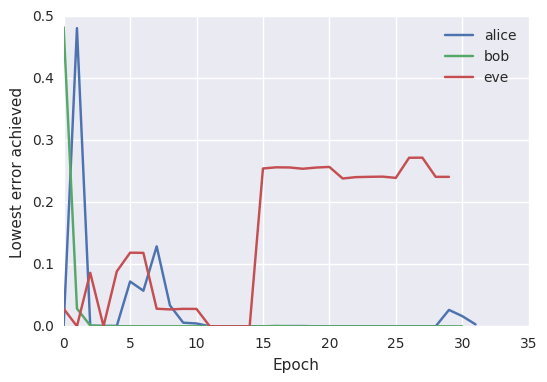

alice_errors_train =  [0.00034071674, 0.48095936, 0.00097656436, 0.00073938817, 0.00070087158, 0.072279774, 0.057399161, 0.12900548, 0.033768605, 0.0058621117, 0.0046170717, 5.4499113e-05, 3.6152604e-05, 2.2578446e-05, 1.3850595e-05, 6.2894483e-06, 2.5148611e-06, 0.00042566925, 0.00046699762, 2.7544716e-05, 8.0012396e-06, 2.819841e-06, 8.5528882e-07, 3.369496e-07, 8.9406967e-08, 6.3970219e-08, 1.196895e-08, 4.7293724e-09, 2.4738256e-09, 0.026489239, 0.016481312, 0.0031665408]
bob_errors_train =  [0.48254484, 0.028678708, 0.0013088954, 0.00038241441, 0.00016329822, 0.00010313131, 8.1380698e-05, 5.8885529e-05, 5.1141596e-05, 3.9537881e-05, 3.6108511e-05, 2.5381143e-05, 1.5330905e-05, 1.1075083e-05, 3.7914479e-06, 8.4909868e-07, 0.00069179997, 0.00018471357, 8.6339547e-05, 5.288524e-05, 4.1389965e-05, 3.4827983e-05, 2.7390042e-05, 2.5248211e-05, 2.4559069e-05, 2.3195362e-05, 2.0359796e-05, 1.8153803e-05, 1.8224118e-05, 1.6720402e-05, 1.5741211e-05]
eve_errors_train =  [0.028392296, 0.0001

In [15]:
import time
epochs = 15
#sess = tf.InteractiveSession()
sess = tf.Session()

#with tf.Session() as sess:
print('Starting Training Process... ')
start_time = time.time()
train(sess)
end_time = time.time()
print('Time taken for Training (seconds): ', end_time-start_time)
plot_results()

print('alice_errors_train = ', alice_errors)
print('bob_errors_train = ', bob_errors)
print('eve_errors_train = ', eve_errors)    


## Testing

The above section of the code for training the CNN does not have to be rerun if the user decides to input another message.

In [16]:
import binascii
def stringize(data):
    b1_temp = np.rint(data)
    b1_temp = b1_temp.ravel();
    b1_temp = np.abs(b1_temp)
    b2_temp  = np.array2string(b1_temp)
    b2_temp = b2_temp.strip('[')
    b2_temp = b2_temp.strip(']')
    b2_temp = b2_temp.replace(" ", "")
    b2_temp = b2_temp.replace(".", "")
    b2_temp = b2_temp.replace("\n", "")
    print('\tBinary = ',  b2_temp)
    s1 =  ''.join([ "%x"%int(bin,2) for bin in b2_temp.split() ])
    #Pad for SHA256 (32 Bytes = 64 digits)
    s1 = s1.zfill(64)

    return s1

#Test the Neural Crypto model
start_time = time.time()
print( 'Testing Alice' )
alice_loss_test, alice_sign_time, alice_h2_conv_1,_,_, _, _,_ = test('alice', sess)
print('alice_errors_test = ', alice_loss_test)
print( 'Testing Bob' )
_,_,_,bob_loss_test, bob_sign_time, bob_output_1,bob_h2_conv_1,_ = test('bob', sess)
print('bob_errors_test = ', bob_loss_test)    
print( 'Testing Eve' )
_, _,_,_,_,_,_,eve_loss_test = test('eve', sess)
print('eve_errors_test = ', eve_loss_test)
end_time = time.time()
print('Time taken for Testing (seconds): ', end_time-start_time)

#print('alice_output_sign=', alice_output_sign)
print('Alice Computed Signature*********')
alice_sign = stringize(alice_output_sign)
print('\tHex = ', alice_sign)
print('Bob Computed Signature*********')
bob_sign = stringize(bob_output_1)
print('\tHex = ', bob_sign)

if (alice_sign == bob_sign):
    print('Alice and Bob Signature (32 bytes) Verification SUCCESS!')
else:
    print('Alice and Bob Signature (32 bytes) Verification ERROR')
    

Testing Alice
messages = 
 [[ 0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
 [ 0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
 [ 0.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.]
 [ 0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
 [ 0.  1.  1.  1.  0.  1.  0.  0.  

## Performance Benchmarking with cryptography.fernet

Fernet is an implementation of symmetric encryption. It uses AES for encryption and SHA256 for authentication, with initialization vectors generated using os.urandom(). The following code compares SHA256 to NCA in terms of time.

In [ ]:
#Install the Cryptography module
pip install cryptography

In [17]:
from cryptography.fernet import Fernet
key = Fernet.generate_key()
cipher_suite = Fernet(key)
#Preprocess the array from input block above
v2 = []
for i in range(0, len(b1)):
    v2.append(int(b1[i]))
    
print('Cryptography.fernet SHA256 sign/verify sessions')
print('------------------------------------------------')

from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes, hmac
h = hmac.HMAC(key, hashes.SHA256(), backend=default_backend())
start_time = time.time()
h.update(bytes(v2))
hash_val = h.finalize() 
end_time = time.time()
fernet_sign_time = end_time - start_time


print('*********Performance of NCA versus Cryptography.Fernet********************')
print('Time taken for Alice to Sign the Plain Text (seconds): ', alice_sign_time)
print('Time taken for Fernet to Sign the Plain Text (seconds): ', fernet_sign_time)


Cryptography.fernet SHA256 sign/verify sessions
------------------------------------------------
*********Performance of NCA versus Cryptography.Fernet********************
Time taken for Alice to Sign the Plain Text (seconds):  0.015861988067626953
Time taken for Fernet to Sign the Plain Text (seconds):  0.0002117156982421875


# Conclusion

In this notebook, I have demonstrated the unique capability of neural networks to ensure integrity and authenticity through digital signatures comparable to SHA256. 

Future work also includes implementing the sockets over Internet Protocol, instead of localhost. In addition, other goals include implementing Eve and her socket as part of the crypto-pipeline and transmitting signatures appended to the plaintext across the sockets. It would also be interesting to inspect if Eve is able to compute the signature of a plaintext message through the Eve_Hidden layer and reach similar results as Bob and Alice. 

Another important field that I would like to explore is the combination of quantum and neural cryptography. Quantum cryptography involves altering the contents of a message in transit as soon as the attacker (Eve) sees it; this guarantees the integrity of the message. For example, quantum cryptography could be used as a potential channel for transmission of messages encrypted through NCA.  